In [8]:
from datetime import datetime, timedelta

import finnhub
import pandas as pd

from flows import env

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from  matplotlib.ticker import FuncFormatter

In [2]:
finnhub_client = finnhub.Client(api_key=env.FINNHUB_API_KEY)

symbol = "BKR"
today: str = datetime.now().date().strftime("%Y-%m-%d")
one_year_ago: str = (datetime.now().date() - timedelta(days=1 * 365)).strftime(
    "%Y-%m-%d"
)

# insider info plot

In [3]:
insider_info = finnhub_client.stock_insider_transactions(
    symbol=symbol,
    _from=one_year_ago,
    to=today,
)
data = insider_info["data"]

In [4]:
df = pd.DataFrame(data)
# chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://www.sec.gov/about/forms/form4data.pdf
# code S is the sale of private assets. There are others that might apply, but this
# is a simple one
df = df.query("transactionCode=='S'")

df.transactionDate = pd.to_datetime(df.transactionDate)
df = df.sort_values("transactionDate", ascending=True)
# we drop a bit of data, but we expect these values to be very similar so it's fine
df = df.drop_duplicates(subset="transactionDate")
df = df.set_index("transactionDate")

rule = 30
sparse = df.index.to_series().diff().dt.days.ge(rule)
new_timestamps = df.index[sparse] - pd.Timedelta(days=rule)
df_ = df.reindex(df.index.union(new_timestamps))
df_["month"] = df_.index.astype(str).str[0:7]
month_ma = df_.groupby("month").transactionPrice.mean().interpolate()
month_ma.name = "month_moving_average"
df_ = df_.merge(month_ma, on="month")
insider_price_month_average = (
    df_[["month", "month_moving_average"]].drop_duplicates().reset_index(drop=True)
)
insider_price_month_average.head()

,month,month_moving_average
0,2023-07,35.60
1,2023-08,35.16
2,2023-09,36.56
3,2023-10,35.20
4,2023-11,34.49


In [5]:
ar_data = pd.DataFrame(finnhub_client.recommendation_trends(symbol))
ar_data["month"] = ar_data["period"].str[0:7]
pdf = insider_price_month_average.merge(ar_data, on="month", how="outer")

In [6]:
pdf.head()

,month,month_moving_average,buy,hold,period,sell,strongBuy,strongSell,symbol
0,2023-07,35.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08,35.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-09,36.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10,35.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-11,34.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN


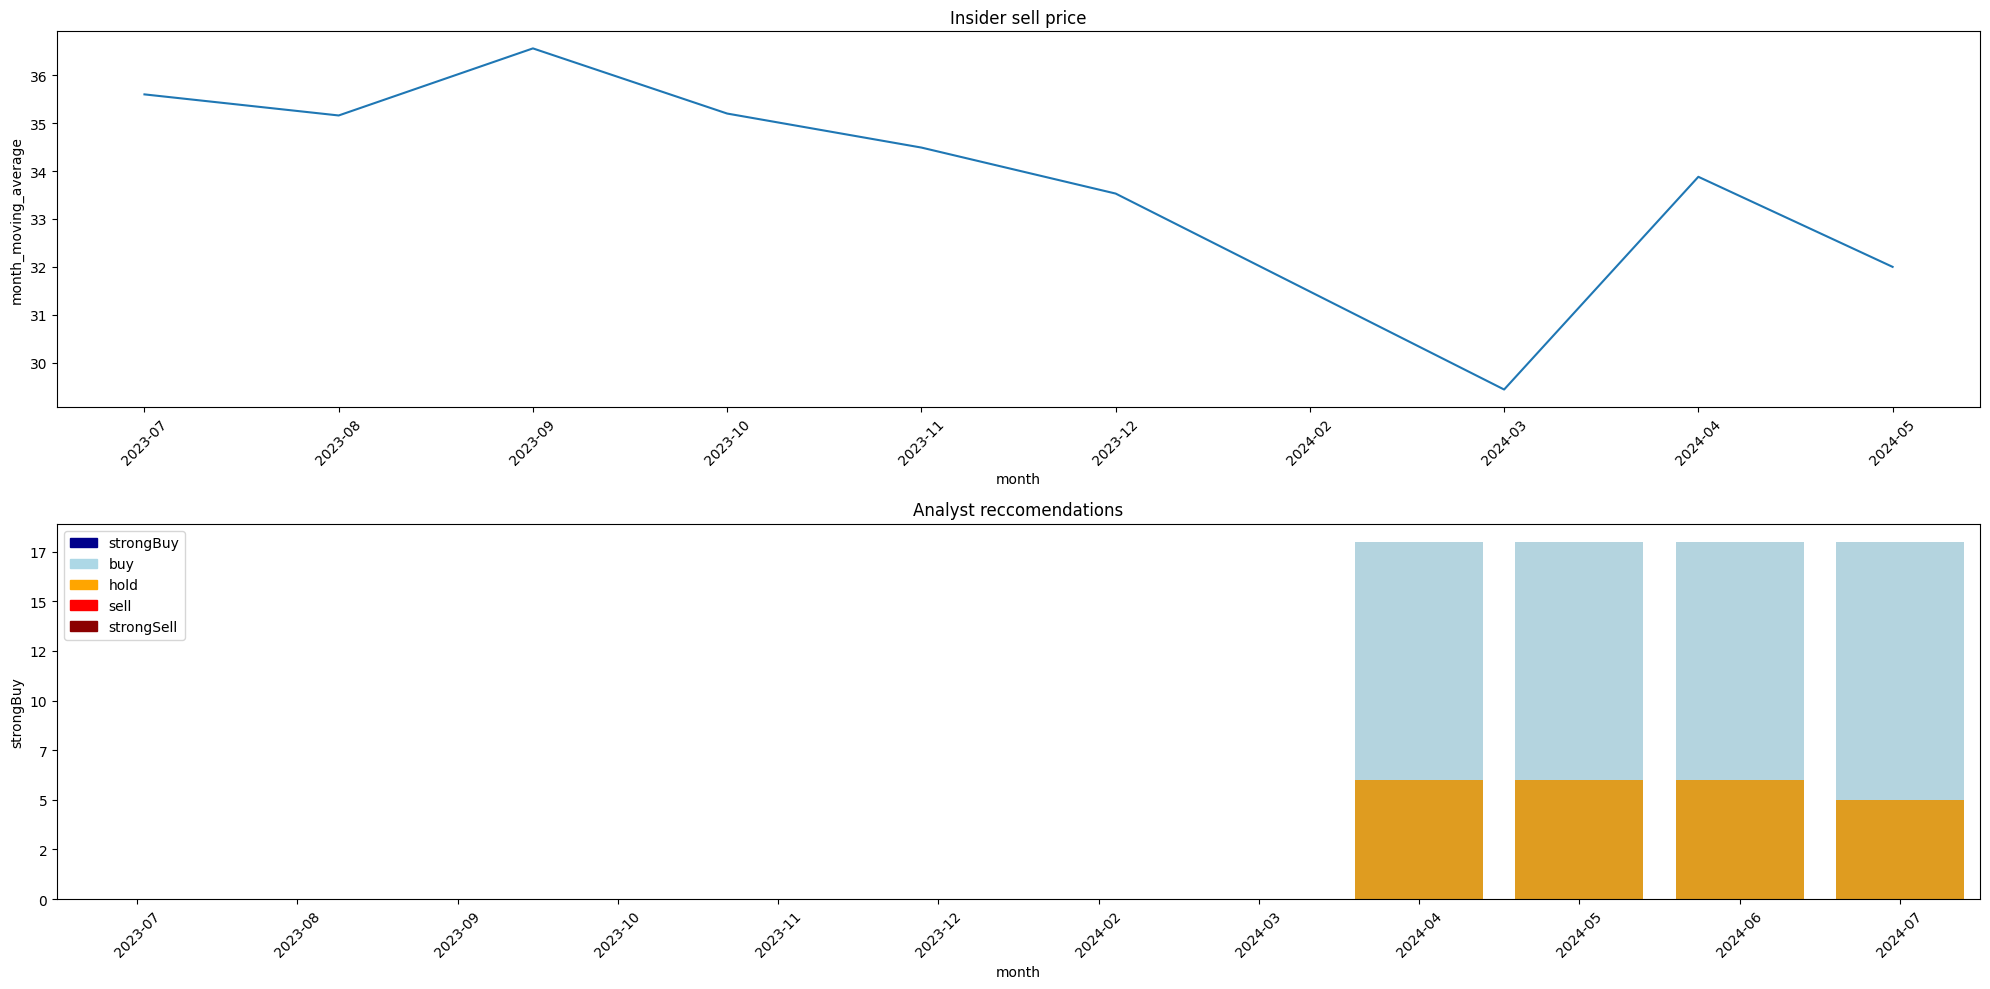

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
mma = sns.lineplot(
    pdf,
    x="month",
    y="month_moving_average",
    ax=axes[0],
)
axes[0].tick_params(axis="x", rotation=45)
axes[0].set_title("Insider sell price")

patches = [
    ("strongBuy", "darkblue"),
    ("buy", "lightblue"),
    ("hold", "orange"),
    ("sell", "red"),
    ("strongSell", "darkred"),
]
legend_handles = []
for c, col in patches:
    sns.barplot(x="month", y=c, data=pdf, color=col, ax=axes[1])
    legend_handles.append(mpatches.Patch(color=col, label=c))

plt.legend(handles=legend_handles)

axes[1].tick_params(axis="x", rotation=45)
axes[1].set_title("Analyst reccomendations")
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
plt.savefig(f"flows/data/{symbol}_report.png")
plt.show()